In [1]:
# This file takes an Overpass API response for bus routes in Manhattan and
# creates NetworkX subgraphs for each individual route and direction.

In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rtree.index import Index as RTreeIndex
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
import xml.etree.ElementTree as et 
from tqdm import tqdm
import networkx as nx
import json

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS = 'EPSG:4326'
DATA_DIR = '../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [3]:
# Load GraphML for Manhattan (New York, NY).
ny_mg = ox.load_graphml(f'{EXPORTS_DIR}/graphml/manhattan/ny.graphml')

# Store node and edge sets for checking validity.
node_id_set = set(ny_mg.nodes)
edge_id_set = set([(e[0], e[1]) for e in ny_mg.edges])

In [4]:
# Determine bounding box for plotting.
bbox_west = min([ny_mg.nodes[n]['x'] for n in ny_mg.nodes])
bbox_east = max([ny_mg.nodes[n]['x'] for n in ny_mg.nodes])
bbox_north = max([ny_mg.nodes[n]['y'] for n in ny_mg.nodes])
bbox_south = min([ny_mg.nodes[n]['y'] for n in ny_mg.nodes])
bbox = (bbox_north, bbox_south, bbox_east, bbox_west)

In [5]:
def get_route_key(route_ref, direction_index):
    return f'{route_ref.replace(" ", "_")}_{direction_index}'

def get_should_use_route(route_ref):
    # Extract only Manhattan bus routes (these start with M).
    # M60 SBS leaves Manhattan - exclude.
    if route_ref[0:3] == 'M60':
        return False
    return route_ref[0] == 'M'

# Iterate through each relation for a bus route.
def parse_bus_routes_xml(xml):
    route_dict = {}
    root = xml.getroot()
    relations = root.findall('relation')
    for relation in relations:
        ways = relation.findall('.//member[@type="way"]')
        # e.g. M11.
        ref = relation.find('.//tag[@k="ref"]').attrib['v']
        name = relation.find('.//tag[@k="name"]').attrib['v']

        # Extract only Manhattan bus routes (these start with M).
        if get_should_use_route(ref):
            # Create a unique key for different directions of same bus route,
            # e.g. M11_0, M11_1.
            i = 0
            key = get_route_key(ref, i)
            while key in route_dict:
                i += 1
                key = get_route_key(ref, i)

            route_dict[key] = {
                'name': name,
                'ref': ref,
                'way_ids': [int(el.attrib['ref']) for el in ways]
            }

    # Retrieve list of nodes for each way.
    ways = {}
    for way in root.findall('way'):
        nodes = way.findall('nd')
        ways[int(way.attrib['id'])] = [int(el.attrib['ref']) for el in nodes]

    # Concatenate the lists of nodes of the ways that form each route.
    for route in route_dict.values():
        for way_id in route['way_ids']:
            if 'node_ids' in route:
                route['node_ids'] = route['node_ids'] + ways[way_id][1:]
            else:
                route['node_ids'] = ways[way_id]
                
    return route_dict

# Load OSM Overpass API XML.
ny_xml = et.parse(f'{DATA_DIR}/overpass/manhattan/bus_routes.osm')
route_dict = parse_bus_routes_xml(ny_xml)

In [6]:
def replace_route_invalid_nodes(route_dict, mg):
    """Removes invalid nodes from the given routes dictionary and replaces them
    with nodes for the shortest path in the given road network multi-graph
    between first and last valid nodes."""
    for route in route_dict.values():
        node_ids = route['node_ids']

        # Find the first valid node for the route.
        start = 0
        for i, node_id in enumerate(node_ids):
            if node_id in node_id_set:
                start = i
                break

        new_node_ids = [node_ids[start]]
        p0 = start
        p1 = start + 1

        # Iterate through the list of nodes for the route with two pointers.
        while p1 < len(node_ids):
            # Advance if the lead pointer is a valid node.
            if node_ids[p1] in node_id_set:
                new_node_ids.append(node_ids[p1])
                p0 += 1
                p1 += 1
            else:
                # Advance the lead pointer to the next valid node and fill the
                # nodes inbetween the two points with the shortest path between.
                p2 = p1 + 1
                while p2 < len(node_ids):
                    if node_ids[p2] in node_id_set:
                        # An improved version should choose the path that most
                        # closely follows the GeoJSON multi-line path.
                        new_path = ox.shortest_path(
                            mg, node_ids[p0], node_ids[p2])[1:]
                        new_node_ids += new_path
                        break
                    p2 += 1
                p0 = p2
                p1 = p2 + 1
        route['node_ids'] = new_node_ids

In [7]:
def remove_route_cycles(route_dict, MAX_CYCLE_LENGTH=50):
    """Removes node cycles from the given route dictionary that could have
    formed while filling the shortest path betwen nodes or from invalid node
    lists from the Overpass API. This assumes that legitimate bus routes do not
    revisit the same node within MAX_CYCLE_LENGTH nodes."""
    for route in route_dict.values():
        node_ids = route['node_ids']
        valid_ids = []
        node_visit_dict = {}

        # Create a parallel list of nodes marking which to skip if they are part
        # of a cycle.
        for i, node_id in enumerate(node_ids):
            valid_ids.append(1)
            if node_id not in node_visit_dict:
                node_visit_dict[node_id] = i
            else:
                # If a node is visited twice, mark all nodes between the first
                # visit and now (exclusive) as part of a cycle.
                j = node_visit_dict[node_id]
                node_visit_dict[node_id] = i
                
                # If a node is revisited after MAX_CYCLE_LENGTH nodes, don't
                # consider it a cycle.
                if i - j > 50:
                    print(i - j, route['ref'])
                if i - j <= MAX_CYCLE_LENGTH:
                    for k in range(j, i):
                        valid_ids[k] = 0

        # Iterate through the nodes and only keep those not marked as in a
        # cycle.
        new_node_ids = []
        for i, node_id in enumerate(node_ids):
            if valid_ids[i]:
                new_node_ids.append(node_id)
        route['node_ids'] = new_node_ids

In [8]:
def replace_route_invalid_edges(route_dict, mg):
    """Replaces invalid edges in the given route dictionary with shortest paths.
    The previous node-filling operations may have added or removed nodes in
    sequences that do not have connecting edges."""
    for route in route_dict.values():
        node_ids = route['node_ids']
        new_node_ids = [node_ids[0]]

        p0 = 0
        p1 = 1

        while p1 < len(node_ids):
            node_id_0 = node_ids[p0]
            node_id_1 = node_ids[p1]
            if (node_id_0, node_id_1) in edge_id_set:
                new_node_ids.append(node_id_1)
            else:
                # An improved version should choose the path that most
                # closely follows the GeoJSON multi-line path.
                new_path = ox.shortest_path(mg, node_id_0, node_id_1)[1:]
                new_node_ids += new_path
            p0 += 1
            p1 += 1

        route['node_ids'] = new_node_ids

In [9]:
replace_route_invalid_nodes(route_dict, ny_mg)
remove_route_cycles(route_dict)
replace_route_invalid_edges(route_dict, ny_mg)

84 M22
84 M22
93 M22
93 M22
93 M22
93 M22
93 M22
93 M22
93 M22
93 M22
93 M22
93 M22
93 M22
420 M55
91 M4
71 M10
53 M35
53 M35
135 M35
135 M35
135 M35
135 M35
60 M35
146 M35
77 M35
106 M35
106 M35
106 M35
106 M35
106 M35
106 M35
106 M35


In [10]:
def get_edges_from_node_sequence(node_ids):
    return [(node_ids[i], node_ids[i + 1], 0) for i in range(len(node_ids) - 1)]

# Create and export subgraph of all bus routes.
all_edges = []
for route in route_dict.values():
    route['edges'] = get_edges_from_node_sequence(route['node_ids'])
    all_edges += route['edges']
routes_mg = ny_mg.edge_subgraph(all_edges)

ox.save_graphml(routes_mg, f'{EXPORTS_DIR}/graphml/manhattan/routes.graphml')

# Create and export subgraphs for each bus route.
for route in route_dict.values():
    route['graph'] = ny_mg.edge_subgraph(route['edges'])
    ox.save_graphml(route['graph'], f'{EXPORTS_DIR}/graphml/manhattan/routes/{route["ref"]}.graphml')

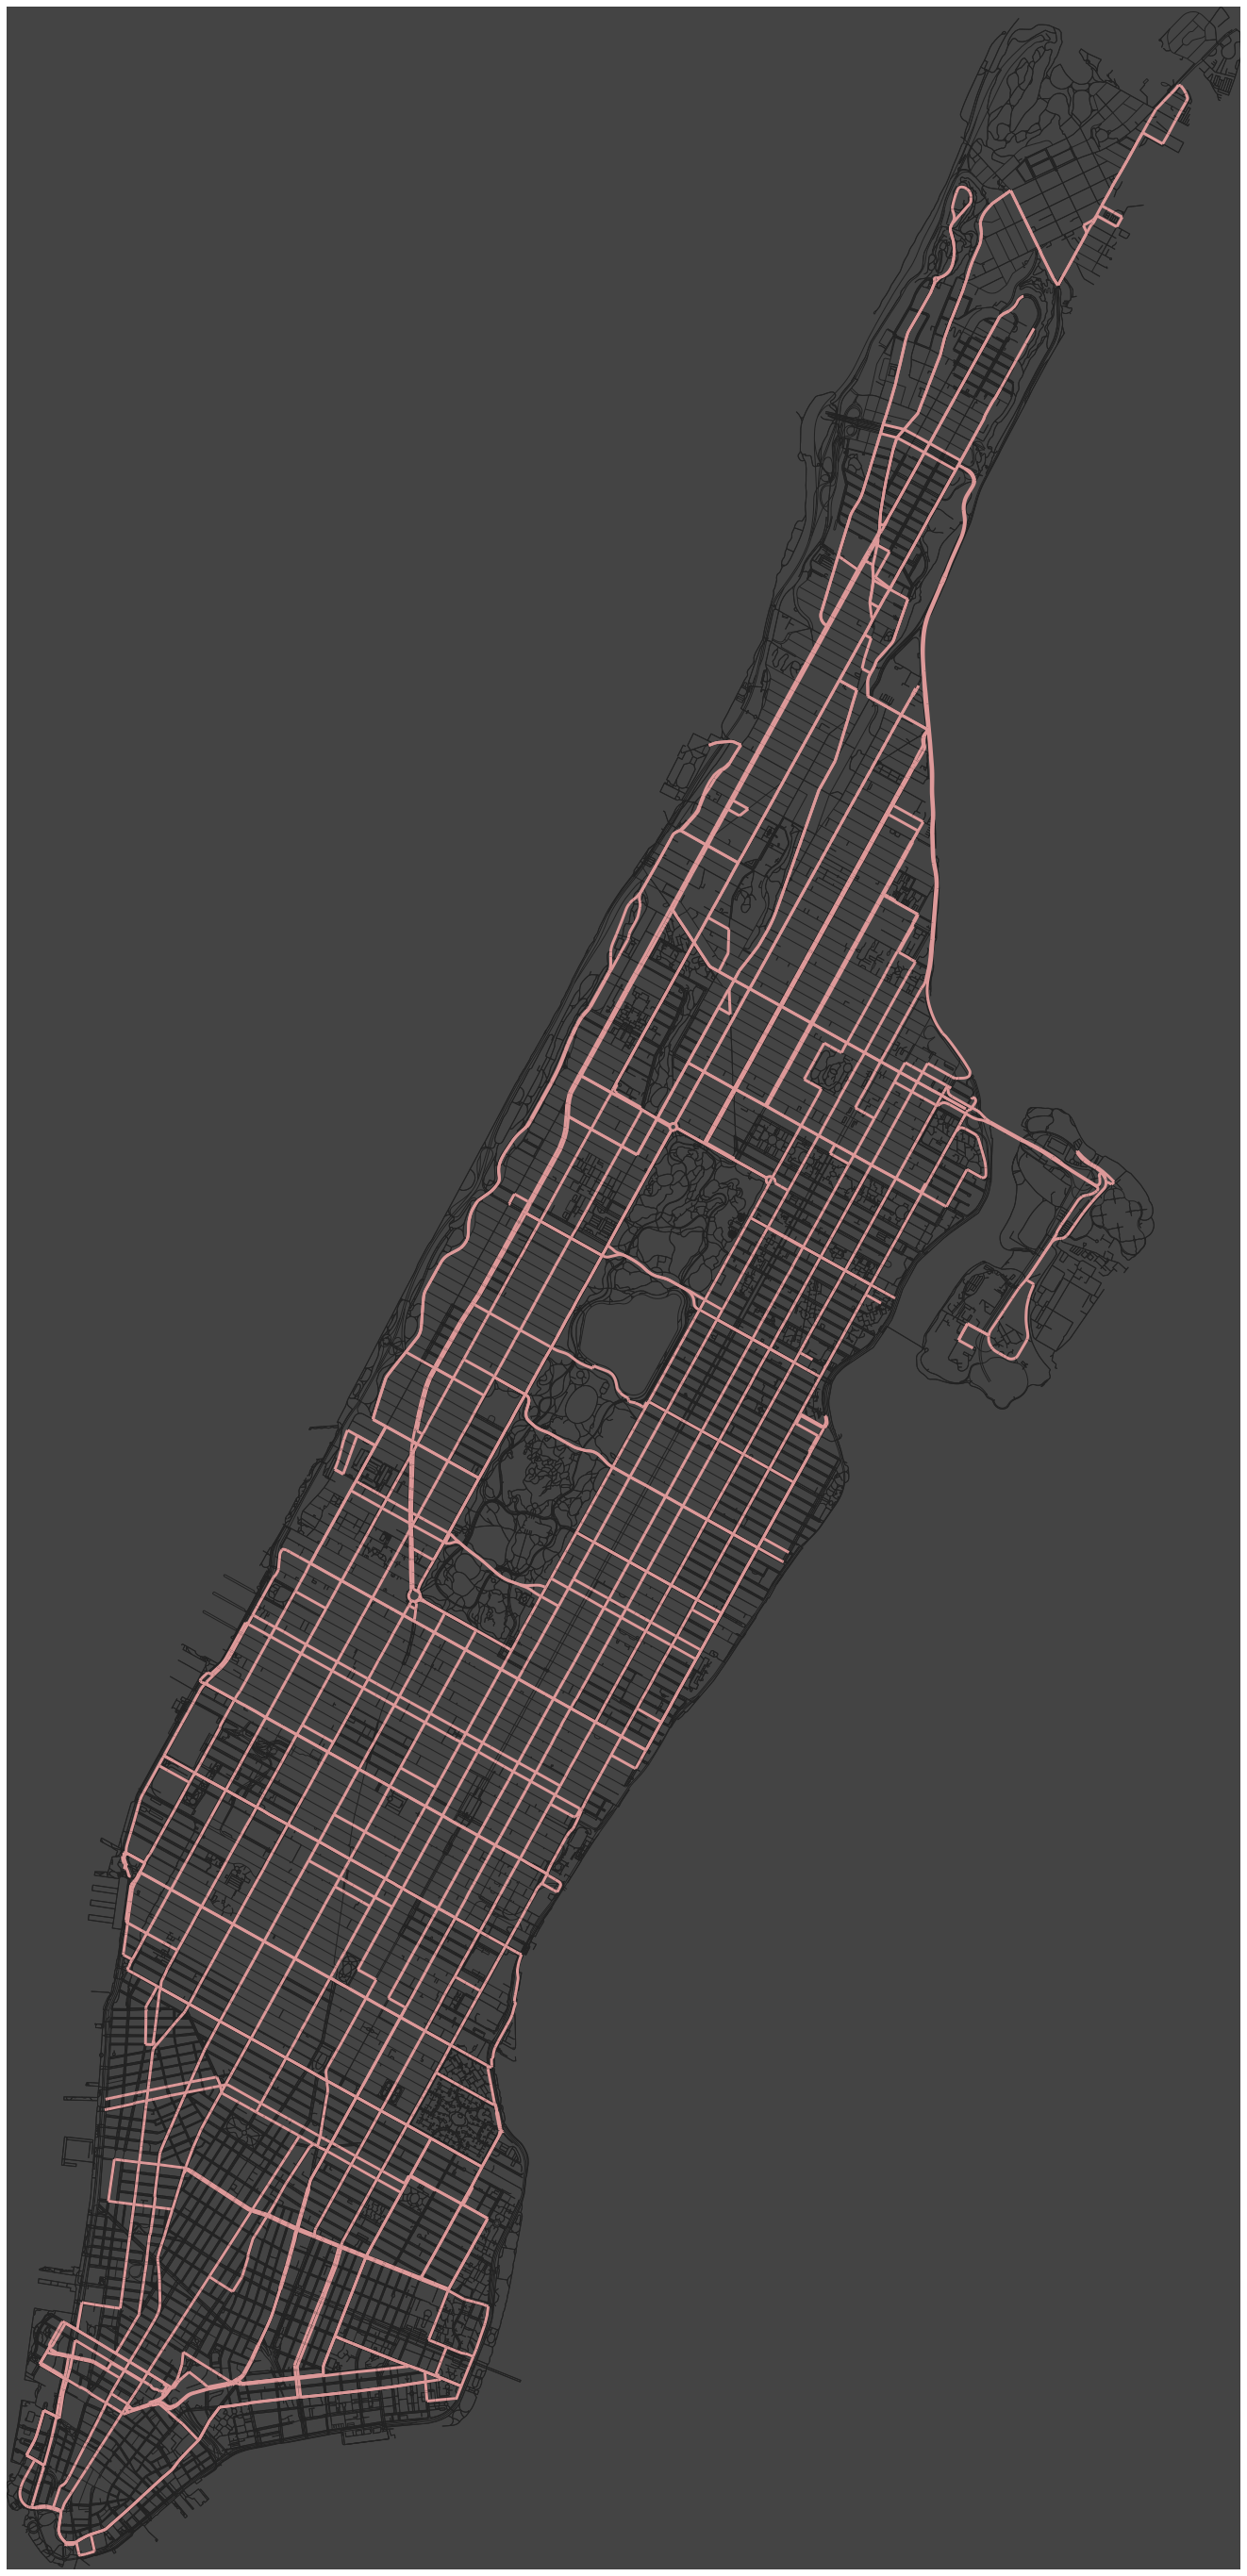

In [13]:
# Plot all collected routes to visualize network coverage.
fig, ax = plt.subplots(figsize=(50, 50))
ox.plot_graph(ny_mg,
              ax=ax,
              bgcolor='#444',
              node_size=0,
              show=False,
              close=False,
              edge_color='#222222',
              bbox=bbox)
ox.plot_graph(routes_mg,
              ax=ax,
              bgcolor='#444',
              node_size=0,
              show=False,
              close=False,
              edge_color='#dd9999',
              edge_linewidth=3,
              bbox=bbox)
ax.set_facecolor('#444')

In [13]:
# Export all extracted routes and nodes to a JSON file for later notebooks.
routes_export = {}
for key, route in route_dict.items():
    routes_export[key] = {
        'name': route['name'],
        'ref': route['ref'],
        'node_ids': route['node_ids'],
        'edges': route['edges'],
    }

with open(f'{EXPORTS_DIR}/json/manhattan/routes.json', 'w') as file:
    json.dump(routes_export, file)

In [14]:
with open(f'{EXPORTS_DIR}/json/manhattan/routes.json') as file:
    routes_json = json.load(file)

In [15]:
routes_gtfs_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/routes.txt')

In [16]:
def get_route_color(route_ref):
    """Returns the GTFS-specified hex color for the route with the given ID."""
    # M86 is incorrectly marked as not an SBS route. SBS routes all have same
    # color.
    if 'SBS' in route_ref or route_ref == 'M86':
        return '#086cb5'

    # Otherwise look up correct color.
    return f'#{routes_gtfs_df[routes_gtfs_df["route_id"] == route_ref]["route_color"].iloc[0]}'


def plot_graphs(route_ref, graphs):
    """Plots the routes for all directions of the bus route with the given ID
    using the given NetworkX subgraphs."""
    fig, ax = plt.subplots(figsize=(50, 50))
    ox.plot_graph(ny_mg,
                  ax=ax,
                  bgcolor='#444',
                  node_size=0,
                  show=False,
                  close=False,
                  edge_color='#222222',
                  bbox=bbox)
    for graph in graphs:
        ox.plot_graph(graph,
                      ax=ax,
                      bgcolor=None,
                      node_size=0,
                      show=False,
                      close=False,
                      edge_color=get_route_color(route_ref),
                      edge_linewidth=2,
                      edge_alpha=0.5,
                      bbox=bbox)
    ax.set_facecolor('#444')
    fig.savefig(f'{EXPORTS_DIR}/img/manhattan/{route_ref}.png', bbox_inches='tight')
    plt.close(fig)

In [17]:
# Group all route direction subgraphs by their route ID.
graphs_by_ref = {}
for key, route in route_dict.items():
    # Get the route by removing the "_n" suffix.
    ref = route['ref']
    if not ref in graphs_by_ref:
        graphs_by_ref[ref] = {}
    graphs_by_ref[ref][key] = route['graph']

In [18]:
# Plot all routes to exported PNG files.
for ref in tqdm(graphs_by_ref.keys()):
    plot_graphs(ref, graphs_by_ref[ref].values())

100%|██████████| 40/40 [06:55<00:00, 10.38s/it]
